## mDC proportion analysis - cell-cell communication to find differentially expressed 
#interactions between mDC high samples and mDC low samples

- Author: CW
- Files needed: cell_communication_analysis/2_significant_interactions_celltype, cell_communication_analysis/2_significant_interactions_subtype
- File outputs/for plots: mDC_proportion_analysis/cell_communication_LR_results_celltype_no_zero_means.csv, mDC_proportion_analysis/cell_communication_LR_results_celltype_w_zero_means.csv
- Last updated: 04/13/24

We want to test whether the differences from interaction expression are different between mDC high and low samples. To adjust for covariates, we need to use a different model other than the Wilcoxon rank sum test. We can use logistic regression to model the outcome.  

In [1]:
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## 1. Collect all interactions by all pairs from every sample 

In [2]:
file_path <- './cell_communication_analysis/cpdb_celltype/2_significant_interactions_celltype'

In [3]:
ccc_results <- read.csv(paste0(file_path,'/all_samples_reannotatedall.tsv'), sep = '\t', 
                       row.names = 'X')

In [7]:
colnames(ccc_results)

[1] "interacting_pair"  "partner_a"         "partner_b"        
 [4] "gene_a"            "gene_b"            "receptor_a"       
 [7] "receptor_b"        "secreted"          "interacting_cells"
[10] "significant_mean"  "sample"

In [10]:
ccc_results_ixns <- ccc_results %>% select(c('interacting_pair', 'partner_a', 'partner_b', 
                         'interacting_cells'))
unique_ccc_results_ixns <- unique(ccc_results_ixns)

unique_ccc_results_ixns are the unique interactions across all samples and those that we will want to test across all samples

## 2. Gather metadata and covariates for each sample

- covariates: age, sex, treatment_group, tissue
- predictor: is mDC high

In [13]:
clinical.metadata <- read.csv('/path_to_file/Supplementary_Table_1.csv', 
                             row.names = 'X')

In [14]:
colnames(clinical.metadata)

[1] "sample_ID_long"       "patient"              "uid"                 
 [4] "age"                  "sex"                  "subtype"             
 [7] "sample_date"          "treatment"            "treatment_group"     
[10] "adjuvant"             "ICI"                  "prior_therapy"       
[13] "state"                "pfs"                  "censure_pfs"         
[16] "os"                   "censure_os"           "tissue"              
[19] "notes_normal_primary" "in_retrospective"     "include"             
[22] "driver_mutations"     "BRAF"                 "NRAS"                
[25] "NF1"                  "TERT"                 "TP53.TP63"           
[28] "PTEN"                 "MAP2K1.MAP3K2"        "scRNA"               
[31] "snATAC"               "day_to_treatment"     "overall_response"    
[34] "response_short"       "with_ICI"             "ICI_only"            
[37] "mregDC_out_of_cDC"    "is_mregDC_high"       "mregDC_status"       
[40] "patient_sample"       "ATAC_sample_ID"

In [15]:
#take out 1122_1
clinical.metadata <- clinical.metadata[!clinical.metadata$patient_sample == '1122_1',]

In [16]:
#format the covariates before encoding into the design matrix 
#for with ICI samples - with ICI, ICI only, antiPD1
clinical.metadata$treatment_group_new <- "other"

clinical.metadata[clinical.metadata$treatment_group %in% c('ICI_PD1','ICI_combo', 'targeted_plus_ICI', 
                           'other_plus_ICI'),]$treatment_group_new <-  "with_ICI"

clinical.metadata[clinical.metadata$treatment_group %in% c('ICI_PD1','ICI_combo'),]$treatment_group_new <- "ICI_only"

clinical.metadata[clinical.metadata$treatment_group == 'ICI_PD1',]$treatment_group_new <- "ICI_PD1"

#all celltypes and groups, make tissue three categories 
clinical.metadata[clinical.metadata$tissue == 'skin',]$tissue <- 'skin'
clinical.metadata[clinical.metadata$tissue == 'lymph', ]$tissue <- 'lymph'
clinical.metadata[!clinical.metadata$tissue %in% c('skin', 'lymph'), ]$tissue <- 'other' 

In [17]:
head(clinical.metadata)

,sample_ID_long,patient,uid,age,sex,subtype,sample_date,treatment,treatment_group,adjuvant,⋯,overall_response,response_short,with_ICI,ICI_only,mregDC_out_of_cDC,is_mregDC_high,mregDC_status,patient_sample,ATAC_sample_ID,treatment_group_new
,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,⋯,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>
1,D18-11807,946,94610/24/2018,85,M,cutaneous,10/24/18,"ERKi (prior pembro, PDL1+CSF1Ri)",targeted,FALSE,⋯,PR,R,no,no,0.00000000,0,low,946_1,none,other
2,D18-11808,926,92611/01/2018,62,M,cutaneous,11/1/18,pembro,ICI_PD1,FALSE,⋯,PD,NR,yes,yes,0.18478261,0,low,926_1,none,ICI_PD1
3,D18-11809,406,40611/05/2018,70,M,cutaneous,11/5/18,"pembro (prior TVEC, d+t, IFN)",ICI_PD1,FALSE,⋯,PD,NR,yes,yes,0.16438356,0,low,406_3,none,ICI_PD1
4,D19-11960,1224,122408/29/2019,79,M,cutaneous,8/29/19,pembro,ICI_PD1,FALSE,⋯,PD,NR,yes,yes,0.00000000,0,low,1224_3,D19-11983 D19-11984,ICI_PD1
5,D19-11962,1098,109809/16/2019,24,F,cutaneous,9/16/19,"enco+Bini (+ NIVO, prior IPI+NIVO, enco+bini)",targeted_plus_ICI,FALSE,⋯,R,R,yes,no,0.20833333,1,high,1098_5,none,with_ICI
6,D19-11963,1232,123209/13/2019,79,F,mucosal,9/13/19,pembro +PCV,other_plus_ICI,FALSE,⋯,R,R,yes,no,0.02702703,0,low,1232_1,none,with_ICI


In [19]:
# select covariates for model 
model.covariates <- clinical.metadata %>% select(c('sample_ID_long', 
                                                   'patient','age', 'sex', 'tissue', 'treatment_group_new', 
                                                  'is_mregDC_high'))

model.covariates$sample <- model.covariates$sample_ID_long
model.covariates$sample_ID_long <- NULL

In [22]:
#change covariates to design matrix
model.covariates.filt <- model.covariates[,(names(model.covariates) %in% c('tissue', 'treatment_group_new'))]
model.covariates.mat <- data.frame(model.matrix(~.,model.covariates.filt))
#model.covariates.mat$sample <- 'none' 
#model.covariates.mat$sample <- model.covariates$sample
colnames(model.covariates.mat)[1] <- "Intercept"

#add back to model.covariates
model.covariates.final <- cbind(model.covariates %>% select(c('sample','age', 'sex', 'is_mregDC_high')), 
    model.covariates.mat)

In [21]:
head(model.covariates.final)

,sample,age,sex,is_mregDC_high,Intercept,tissueother,tissueskin,treatment_group_newICI_PD1,treatment_group_newother,treatment_group_newwith_ICI
,<chr>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,D18-11807,85,M,0,1,0,1,0,1,0
2,D18-11808,62,M,0,1,0,1,1,0,0
3,D18-11809,70,M,0,1,0,1,1,0,0
4,D19-11960,79,M,0,1,1,0,1,0,0
5,D19-11962,24,F,1,1,0,1,0,0,1
6,D19-11963,79,F,0,1,1,0,0,0,1


## 3. Run logistic regression model to detect differentially expressed interactions between mDC high and low 

### A. Option 1: Fit logistic regression model using all samples (zero and non-zero values )

### get interactions from each sample 

In [23]:
all_ixn_summary <- data.frame(matrix(ncol = 8, nrow = 1))

In [24]:
colnames(all_ixn_summary) <- c('interacting_pair', 'interacting_cells', 'num_nonzero_mDC_high', 
              'num_nonzero_mDC_low', 'avg_nonzero_mean_mDC_high', 'avg_nonzero_mean_mDC_low',
               'sig_mean_coeff', 'sig_mean_pval')

In [25]:
dim(unique_ccc_results_ixns)

[1] 21701     4

#### WARNING: This takes a long time. Table is saved under "/home/cbw3/data/figure_generation/Figure6/ccc_LR_results_celltype.csv"

In [152]:
for(ixn in interaction(unique_ccc_results_ixns$interacting_pair, unique_ccc_results_ixns$interacting_cells)[1]) {
    
    #find interacting pair and interacting cells in the original table 
    ixn_entries <- ccc_results[interaction(ccc_results$interacting_pair, ccc_results$interacting_cells) %in%
                               ixn,]
    
    #merge entries with covariates
    ixns_entries_w_cov <- merge(ixn_entries, model.covariates.final, by = 'sample')

    #get necessary columns 
    stats_for_model <- ixns_entries_w_cov %>% select(append(colnames(model.covariates.final), 'significant_mean'))

    #impute 0 in all 
    
    #make model matrix with just covariates + mDC status 
    samples_stats_wout_ixn <- model.covariates.final[!model.covariates.final$sample %in% ixns_entries_w_cov$sample,]

    if(dim(samples_stats_wout_ixn)[1] > 0) {
        samples_stats_wout_ixn <- cbind(samples_stats_wout_ixn, data.frame(significant_mean = 0))
    }

    stats_for_model_2 <- rbind(stats_for_model, samples_stats_wout_ixn)
    
    model_mat <- stats_for_model_2 %>% select(-c('sample', 'Intercept'))
    
    #run logistic regression
    log_model <- glm(is_mregDC_high ~., data = model_mat, family = "binomial")
    
    sig_mean_est <- summary(log_model)$coefficients[,1][['significant_mean']]
    sig_mean_pval <- summary(log_model)$coefficients[,4][['significant_mean']]
    
    #add to running table of interactions and pvalues

    ixn_summary <- data.frame(interacting_pair = unique(ixn_entries$interacting_pair), 
              interacting_cells = unique(ixn_entries$interacting_cells), 
              num_nonzero_mDC_high = dim(stats_for_model[stats_for_model$is_mregDC_high == 1,])[1], 
              num_nonzero_mDC_low = dim(stats_for_model[stats_for_model$is_mregDC_high == 0,])[1], 
                avg_nonzero_mean_mDC_high = ifelse(!is.nan(mean(stats_for_model[stats_for_model$is_mregDC_high == 1,]$significant_mean)),
                                       mean(stats_for_model[stats_for_model$is_mregDC_high == 1,]$significant_mean), 
                                                                0),
                avg_nonzero_mean_mDC_low = ifelse(!is.nan(mean(stats_for_model[stats_for_model$is_mregDC_high == 0,]$significant_mean)),
                                       mean(stats_for_model[stats_for_model$is_mregDC_high == 0,]$significant_mean), 
                                                                0),
                 sig_mean_coeff = sig_mean_est, 
                   sig_mean_pval = sig_mean_pval)
    

    if(sum(is.na(all_ixn_summary)) == 8) {
        all_ixn_summary <- ixn_summary
    } else {
        all_ixn_summary <- rbind(all_ixn_summary, ixn_summary)
    }
           
    
    
}

In [153]:
sig_mean_est <- summary(log_model)$coefficients[,1][['significant_mean']]

In [165]:
dim(all_ixn_summary)

[1] 21701     8

In [166]:
head(all_ixn_summary)

,interacting_pair,interacting_cells,num_nonzero_mDC_high,num_nonzero_mDC_low,avg_nonzero_mean_mDC_high,avg_nonzero_mean_mDC_low,sig_mean_coeff,sig_mean_pval
,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,CD48_CD244,B|Cycling T,1,3,0.577000,0.9713333,0.396302993,0.8344767
2,TGFB1_TGFBR3,B|Cycling T,1,1,0.745000,1.1160000,2.032808662,0.3478063
3,LTB_LTBR,B|Endothelial,7,16,1.090143,1.0070625,-0.526653685,0.5403998
4,TGFB1_TGFbeta_receptor1,B|Fibroblast,3,7,0.435000,0.4601429,0.009465948,0.9965968
5,LTB_LTBR,B|Fibroblast,7,18,1.094429,1.0177778,-0.771762553,0.4185979
6,TGFB1_TGFbeta_receptor1,B|Monocyte/Macrophage,2,4,0.376000,0.5205000,-1.265056344,0.7064779


In [167]:
write.csv(all_ixn_summary, './mDC_proportion_analysis/cell_communication_LR_results_celltype_w_zero_means.csv')

### B. Option 2: run logistic regression only on samples with non-zero values 
Ran in slurm, took about 35 minutes

In [26]:
#initialize dataframe to hold results
all_ixn_summary <- data.frame(matrix(ncol = 8, nrow = dim(unique_ccc_results_ixns)[1]))
colnames(all_ixn_summary) <- c('interacting_pair', 'interacting_cells', 'num_nonzero_mDC_high', 
              'num_nonzero_mDC_low', 'avg_nonzero_mean_mDC_high', 'avg_nonzero_mean_mDC_low',
               'sig_mean_coeff', 'sig_mean_pval')

In [28]:
row = 1

start = Sys.time()

for(ixn in interaction(unique_ccc_results_ixns$interacting_pair, unique_ccc_results_ixns$interacting_cells)) {
    
    #find interacting pair and interacting cells in the original table 
    ixn_entries <- ccc_results[interaction(ccc_results$interacting_pair, ccc_results$interacting_cells) %in%
                               ixn,]
    
    #merge entries with covariates
    ixns_entries_w_cov <- merge(ixn_entries, model.covariates.final, by = 'sample')

    #get necessary columns 
    stats_for_model <- ixns_entries_w_cov %>% select(append(colnames(model.covariates.final), 'significant_mean'))
    
    avg_mean_mDC_high <- mean(stats_for_model[stats_for_model$is_mDC_high == 1,]$significant_mean)
    avg_mean_mDC_low <- mean(stats_for_model[stats_for_model$is_mDC_high == 0,]$significant_mean)
    #do not add samples with 0 values 
    
    model_mat <- stats_for_model %>% select(-c('sample', 'Intercept'))
    
    if(dim(model_mat[model_mat$is_mDC_high == 0,])[1] <=1 | dim(model_mat[model_mat$is_mDC_high == 1,])[1] <=1) {
        #print('not enough samples to run regression')
        #add interaction to all_ixn_summary
        ixn_summary <- c(unique(ixn_entries$interacting_pair), #interacting_pair 
               unique(ixn_entries$interacting_cells), #interacting_cells
              dim(stats_for_model[stats_for_model$is_mDC_high == 1,])[1], #num_nonzero_mDC_high 
            dim(stats_for_model[stats_for_model$is_mDC_high == 0,])[1], #num_nonzero_mDC_low 
            ifelse(!is.nan(avg_mean_mDC_high), #avg_nonzero_mean_mDC_high
                        avg_mean_mDC_high, 0),
            ifelse(!is.nan(avg_mean_mDC_low), #avg_nonzero_mean_mDC_low
                       avg_mean_mDC_low, 0),
                 'NA', #sig_mean_coeff 
                    'NA') #sig_mean_pval
        all_ixn_summary[row,]<- ixn_summary
        row <- row + 1
        next
    }
    
    #check for covariates with fewer than 2 levels 
    #check for every column that there are two or more levels 
    model_mat <- model_mat[, sapply(model_mat, function(col) length(unique(col))) > 1]

    
    #run logistic regression
    log_model <- glm(is_mDC_high ~., data = model_mat, family = "binomial")
    
    if(!"significant_mean" %in% names(summary(log_model)$coefficients[, 1])) {
        sig_mean_est = 'NA' #may not have enough samples
    } else {
        sig_mean_est <- summary(log_model)$coefficients[,1][['significant_mean']]
    }
    
    if(!"significant_mean" %in% names(summary(log_model)$coefficients[, 4])) {
        sig_mean_pval = 'NA' #may not have enough samples 
    } else  {
        sig_mean_pval <- summary(log_model)$coefficients[,4][['significant_mean']]
    }
    
    
    #add to running table of interactions and pvalues                    
    ixn_summary <- c(unique(ixn_entries$interacting_pair), #interacting_pair 
               unique(ixn_entries$interacting_cells), #interacting_cells
              dim(stats_for_model[stats_for_model$is_mDC_high == 1,])[1], #num_nonzero_mDC_high 
            dim(stats_for_model[stats_for_model$is_mDC_high == 0,])[1], #num_nonzero_mDC_low 
            ifelse(!is.nan(avg_mean_mDC_high), #avg_nonzero_mean_mDC_high
                        avg_mean_mDC_high, 0),
            ifelse(!is.nan(avg_mean_mDC_low), #avg_nonzero_mean_mDC_low
                       avg_mean_mDC_low, 0),
                 sig_mean_est, #sig_mean_coeff 
                    sig_mean_pval) #sig_mean_pval
    

    #add ixn_summary to the next row of the dataframe 
    all_ixn_summary[row,] <- ixn_summary
    row <- row + 1
    
}
end = Sys.time()

print(start - end)

In [ ]:
write.csv(all_ixn_summary, './mDC_proportion_analysis/cell_communication_LR_results_celltype_no_zero_means.csv')

## 4. Visualize significant interactions by mDC high and low  

In [4]:
library(CellChat)

Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: ggplot2



- node size = the total number of interactions per cell type for the cohort 
- edge weights = number of interactions between each pair of cell types (number of samples not taken into account)

In [5]:
#node size = the total number of interactions per cell type for the cohort 
#ex. among the significant interactions higher in the mDC high group, count the number of interactions a particular 
#celltype had 
get_node_size <- function(obj, celltype_order) { 
    
    celltype_sizes <- c()
    for(ct in celltype_order) {
        num_cells <- dim(obj@meta.data[obj$cell_type == ct,])[1]
        celltype_sizes <- append(celltype_sizes, num_cells)
    } 
    
    names(celltype_sizes) <- celltype_order
    return(celltype_sizes)
}

In [6]:
#edge weights = number of interactions between each pair of cell types (number of samples not taken into account)
get_edge_weights <- function(interaction_col, cell_types) {
    
    #print(length(cells))
    cells = strsplit(interaction_col, "[|]")

    weights_mat = data.frame(matrix(ncol = length(cell_types), nrow = length(cell_types)), row.names = cell_types) #all_celltypes
    colnames(weights_mat) = cell_types
    weights_mat[is.na(weights_mat)] <- 0

    for(i in 1:length(interaction_col)) {
        source = cells[[i]][1]
        target = cells[[i]][2]

        weights_mat[source, target]  = weights_mat[source, target] + 1
    }

    return(weights_mat)
}

### A. Option 1 results

In [7]:
all_ixn_summary <- read.csv('./mDC_proportion_analysis/cell_communication_LR_results_celltype_w_zero_means.csv', 
                           row.names = 'X')

#### Cutoffs
- pval < 0.05
- filter out interactions where it is expressed in less than half of the mDC low (n = 27) or mDC high samples (n = 11)

In [8]:
ixn_summary_filt <- all_ixn_summary %>% filter(sig_mean_pval < 0.05, num_nonzero_mDC_high > 11/2, 
                          num_nonzero_mDC_low > 27/2)

In [9]:
ixn_summary_filt

interacting_pair,interacting_cells,num_nonzero_mDC_high,num_nonzero_mDC_low,avg_nonzero_mean_mDC_high,avg_nonzero_mean_mDC_low,sig_mean_coeff,sig_mean_pval
<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
LCK_CD8_receptor,Cycling T|Other T,10,18,1.1251000,0.8052778,3.866378,0.02447026
HEBP1_FPR3,Endothelial|Monocyte/Macrophage,8,15,0.4755000,0.3932667,6.162978,0.04823821
JAG1_VASN,Fibroblast|Fibroblast,11,22,0.4560000,0.4045000,6.122459,0.04503843
Cholesterol_byLIPA_RORA,Monocyte/Macrophage|Other T,7,24,0.6078571,0.6720833,-3.566604,0.04345473
CD86_CD28,cDC|Other T,9,16,0.5158889,0.4066875,8.986546,0.03296139
NECTIN2_TIGIT,cDC|Other T,10,17,0.4114000,0.4232941,8.941251,0.02384728
LTB_LTBR,CD4 T|Endothelial,7,19,1.1115714,1.2677895,-2.244180,0.04237595
LTB_LTBR,CD4 T|Fibroblast,8,21,1.0871250,1.2744762,-2.508621,0.03203353
LTB_LTBR,CD4 T|Monocyte/Macrophage,6,20,1.0483333,1.2203500,-2.065365,0.04610657


- sig_mean_coeff is the exponentiated log odds ratio from logistic regression
- sig_mean_coeff > 0 means interaction may be more predictive towards mDC high 
- sig_mean_coeff < 0 means interaction may be more predictive towards mDC low 

#### get mDC high and low interactions

In [10]:
mDC_low_ixns <- ixn_summary_filt %>% filter(sig_mean_coeff < 0)

In [11]:
mDC_low_ixns

interacting_pair,interacting_cells,num_nonzero_mDC_high,num_nonzero_mDC_low,avg_nonzero_mean_mDC_high,avg_nonzero_mean_mDC_low,sig_mean_coeff,sig_mean_pval
<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Cholesterol_byLIPA_RORA,Monocyte/Macrophage|Other T,7,24,0.6078571,0.6720833,-3.566604,0.04345473
LTB_LTBR,CD4 T|Endothelial,7,19,1.1115714,1.2677895,-2.244180,0.04237595
LTB_LTBR,CD4 T|Fibroblast,8,21,1.0871250,1.2744762,-2.508621,0.03203353
LTB_LTBR,CD4 T|Monocyte/Macrophage,6,20,1.0483333,1.2203500,-2.065365,0.04610657


In [12]:
mDC_high_ixns <- ixn_summary_filt %>% filter(sig_mean_coeff > 0)

In [13]:
mDC_high_ixns

interacting_pair,interacting_cells,num_nonzero_mDC_high,num_nonzero_mDC_low,avg_nonzero_mean_mDC_high,avg_nonzero_mean_mDC_low,sig_mean_coeff,sig_mean_pval
<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
LCK_CD8_receptor,Cycling T|Other T,10,18,1.1251000,0.8052778,3.866378,0.02447026
HEBP1_FPR3,Endothelial|Monocyte/Macrophage,8,15,0.4755000,0.3932667,6.162978,0.04823821
JAG1_VASN,Fibroblast|Fibroblast,11,22,0.4560000,0.4045000,6.122459,0.04503843
CD86_CD28,cDC|Other T,9,16,0.5158889,0.4066875,8.986546,0.03296139
NECTIN2_TIGIT,cDC|Other T,10,17,0.4114000,0.4232941,8.941251,0.02384728
CD55_ADGRE5,pDC|NK,10,16,1.0698000,0.9206875,2.678128,0.03518513
ICAM1_integrin_aLb2_complex,Monocyte/Macrophage|Other T,9,17,0.5824444,0.5264706,4.631111,0.03378374
ICAM1_ITGAL,Monocyte/Macrophage|Other T,9,17,0.5900000,0.5350588,4.181709,0.03864705
CD55_ADGRE5,NK|NK,10,19,1.0041000,0.8153158,2.909903,0.04971173


#### Plotting functions

In [14]:
# cell type colors for plots
celltype_cols = rev(c('Endothelial' = 'orange',
               'Keratinocyte' = 'violet', 'Fibroblast' = 'yellow', 
               'Mast' = 'brown', 'pDC' = 'purple3',
               'cDC' = 'mediumpurple1', 'Cycling T' = '#00F7ff', 
               'NK' = 'blue', 'B' = 'lightblue1', 
               'Other T' = '#00B050', 'Monocyte/Macrophage' = 'magenta',
               'CD4 T' = 'forestgreen', 'CD8 T' = 'skyblue3', 
               'Tumor' = 'coral2'))

- use the same max values so that the plots can be compared side by side

### 1. Plot all interactions together

In [16]:
obj.RNA <- readRDS('/net/bmc-lab5/data/kellis/group/scCancer2023/objects_for_DC_manuscript/for_public/1_RNA_all.rds')
all_ixns_node_size <- get_node_size(obj.RNA, names(celltype_cols))
all_ixns_weights <- get_edge_weights(ixn_summary_filt$interacting_cells, names(celltype_cols))
weight_mat = data.matrix(all_ixns_weights)

Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built with package ‘Matrix’ 1.6.4 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:BiocGenerics’:

    intersect


The following object is masked from ‘package:base’:

    intersect




- Maximum node size: size of largest subset of celltype 

In [17]:
max_node_size = max(all_ixns_node_size)

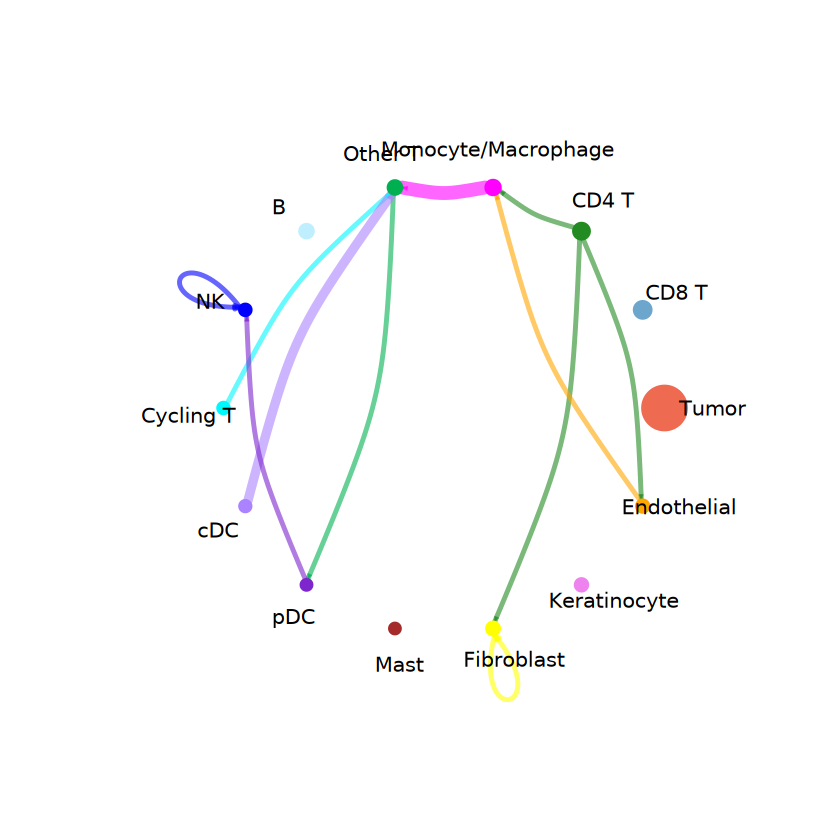

In [18]:
#pdf('./mDC_proportion_analysis/cell_communication_LR_celltype_res/cell_communication_LR_results_celltype_plot_w_zero_means_all_ixns.pdf',
     # width = 11, height = 12)

print(netVisual_circle(weight_mat, vertex.weight = all_ixns_node_size,
                 color.use = celltype_cols, weight.scale = T, edge.weight.max = 3,
                       vertex.weight.max = max_node_size, vertex.label.cex=1, label.edge= F, 
                      title.name = 'all interactions'))

#dev.off()

### 2. Plot mDC high interactions

In [19]:
### for mDC high interactions
obj.RNA.mDChigh <- subset(obj.RNA, subset = is_mDC_high == 1)
mDChigh_ixns_node_size <- get_node_size(obj.RNA.mDChigh, names(celltype_cols))
mDChigh_ixns_weights <- get_edge_weights(mDC_high_ixns$interacting_cells, names(celltype_cols))
mDChigh_weight_mat = data.matrix(mDChigh_ixns_weights)

Loading required package: Seurat

Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode



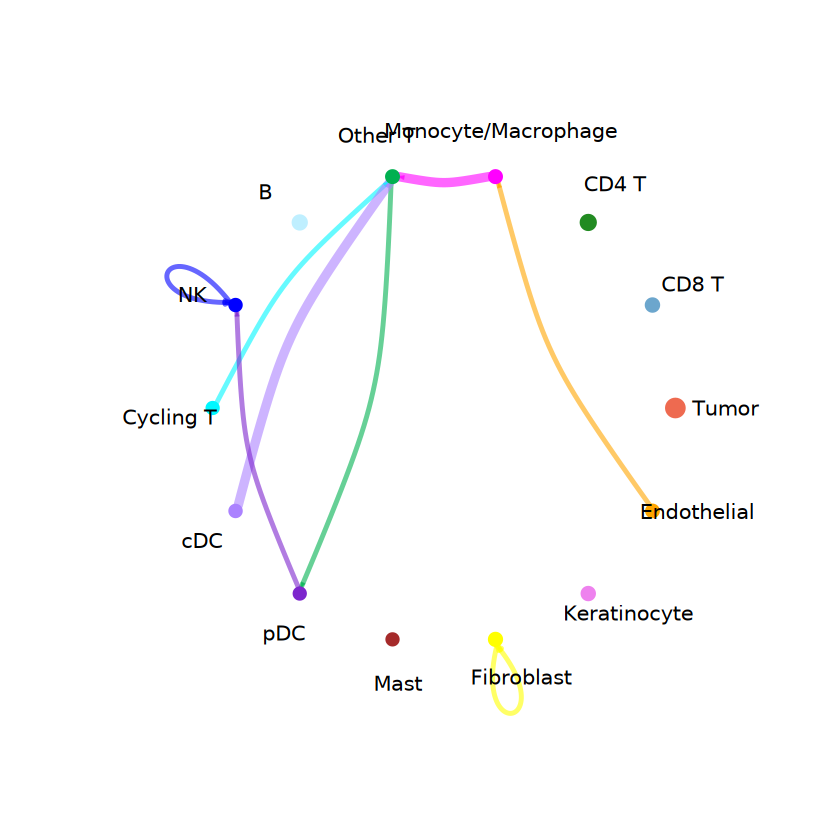

In [171]:
pdf('./mDC_proportion_analysis/cell_communication_LR_celltype_res/cell_communication_LR_results_celltype_plot_w_zero_means_mregDChigh_ixns.pdf',
      width = 11, height = 12)

print(netVisual_circle(mDChigh_weight_mat, vertex.weight = mDChigh_ixns_node_size,
                 color.use = celltype_cols, weight.scale = T, edge.weight.max = 3,
                       vertex.weight.max = max_node_size, vertex.label.cex=1, label.edge= F, 
                      title.name = 'mDC high interactions'))

dev.off()

### 3. Plot mDC low interactions 

In [21]:
### for mDC low interactions
obj.RNA.mDClow <- subset(obj.RNA, subset = is_mDC_high == 0)
mDClow_ixns_node_size <- get_node_size(obj.RNA.mDClow, names(celltype_cols))
mDClow_ixns_weights <- get_edge_weights(mDC_low_ixns$interacting_cells, names(celltype_cols))
mDClow_weight_mat = data.matrix(mDClow_ixns_weights)

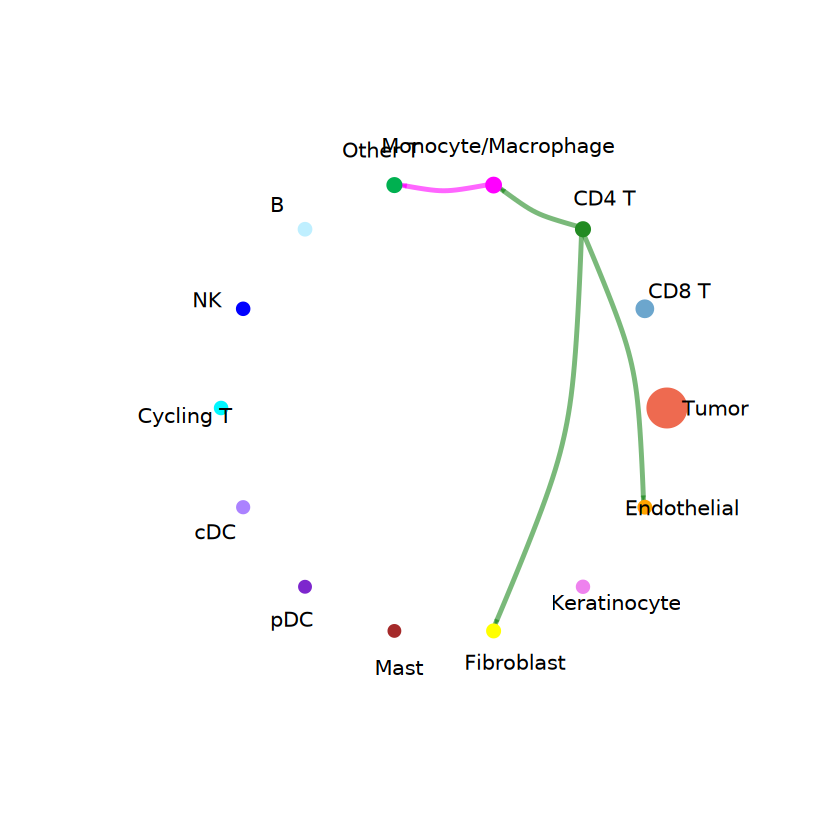

In [23]:
#pdf('./mDC_proportion_analysis/cell_communication_LR_celltype_res/cell_communication_LR_results_celltype_plot_w_zero_means_mregLow_ixns.pdf',
   #   width = 11, height = 12)

print(netVisual_circle(mDClow_weight_mat, vertex.weight = mDClow_ixns_node_size,
                 color.use = celltype_cols, weight.scale = T, edge.weight.max = 3,
                       vertex.weight.max = max_node_size, vertex.label.cex=1, label.edge= F, 
                      title.name = 'mDC low interactions'))

#dev.off()

## B. Option 2 results

In [24]:
all_ixn_summary <- read.csv('./mDC_proportion_analysis/cell_communication_LR_results_celltype_no_zero_means.csv')

#### Cutoffs
- mDC high: sig_mean_coeff > 0
- pval < 0.05
- filter out interactions where it is expressed in less than 6 samples for mDC high or low 

In [25]:
ixn_summary_filt <- all_ixn_summary %>% filter(sig_mean_coeff != 'NA' | sig_mean_pval != 'NA')

In [26]:
print(paste0("Total number of interactions: ", dim(all_ixn_summary)[1]))
print(paste0("Number of interactions with results: ", dim(ixn_summary_filt)[1]))

[1] "Total number of interactions: 21701"
[1] "Number of interactions with results: 4951"


In [27]:
#further filter by pvalue and 6 as the minimum number of samples
ixn_summary_filt <- ixn_summary_filt %>% filter(sig_mean_pval < 0.05, num_nonzero_mDC_high  >= 6, num_nonzero_mDC_low >= 6)

print(paste0("Number of interactions after applying cutoffs: ", dim(ixn_summary_filt)[1]))

[1] "Number of interactions after applying cutoffs: 36"


In [33]:
#filter by mDC high or low 
mDC_low_ixns <- ixn_summary_filt %>% filter(sig_mean_coeff < 0)
mDC_high_ixns <- ixn_summary_filt %>% filter(sig_mean_coeff > 0)

print(paste0("Number of mDC low interactions: ", dim(mDC_low_ixns)[1]))
print(paste0("Number of mDC high interactions: ", dim(mDC_high_ixns)[1]))

[1] "Number of mDC low interactions: 13"
[1] "Number of mDC high interactions: 23"


### 1. Plot all interactions

In [46]:
#obj.RNA <- readRDS('/path_to_file/1_RNA_all.rds')
all_ixns_node_size <- get_node_size(obj.RNA, names(celltype_cols))
all_ixns_weights <- get_edge_weights(ixn_summary_filt$interacting_cells, names(celltype_cols))
weight_mat = data.matrix(all_ixns_weights)

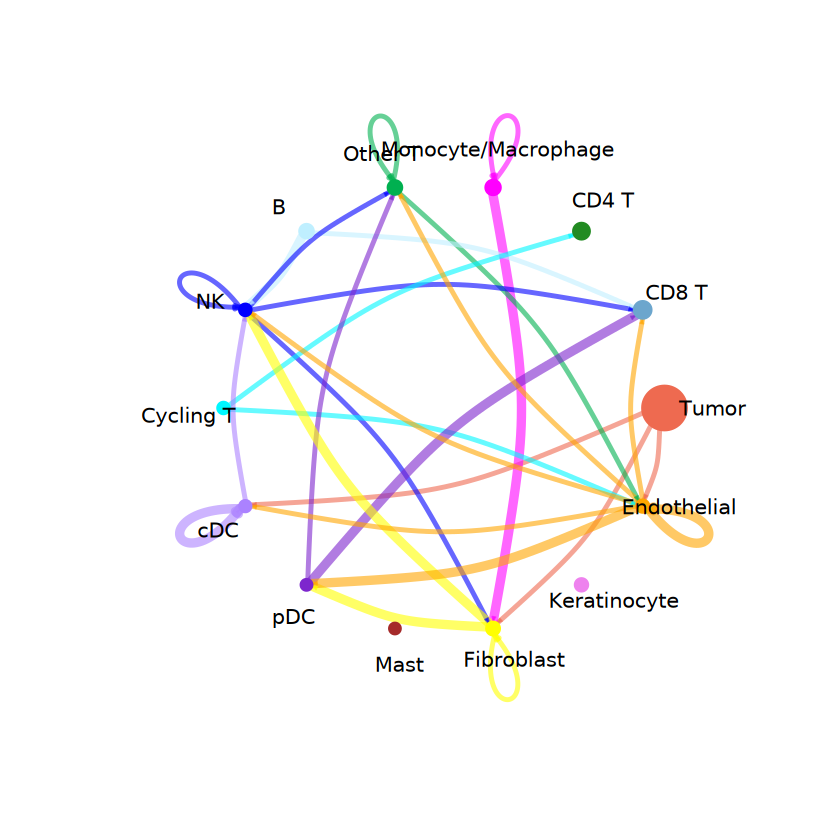

In [48]:
#pdf('./mDC_proportion_analysis/cell_communication_LR_celltype_res/cell_communication_LR_results_celltype_plot_no_zero_means_all_ixns.pdf',
   #   width = 11, height = 12)

print(netVisual_circle(weight_mat, vertex.weight = all_ixns_node_size,
                 color.use = celltype_cols, weight.scale = T, edge.weight.max = 3,
                       vertex.weight.max = max_node_size, vertex.label.cex=1, label.edge= F, 
                      title.name = 'all interactions'))

#dev.off()

### 2. Plot mDC high interactions

In [40]:
### for mDC high interactions
#obj.RNA.mDChigh <- subset(obj.RNA, subset = is_mDC_high == 1)
mDChigh_ixns_node_size <- get_node_size(obj.RNA.mDChigh, names(celltype_cols))
mDChigh_ixns_weights <- get_edge_weights(mDC_high_ixns$interacting_cells, names(celltype_cols))
mDChigh_weight_mat = data.matrix(mDChigh_ixns_weights)

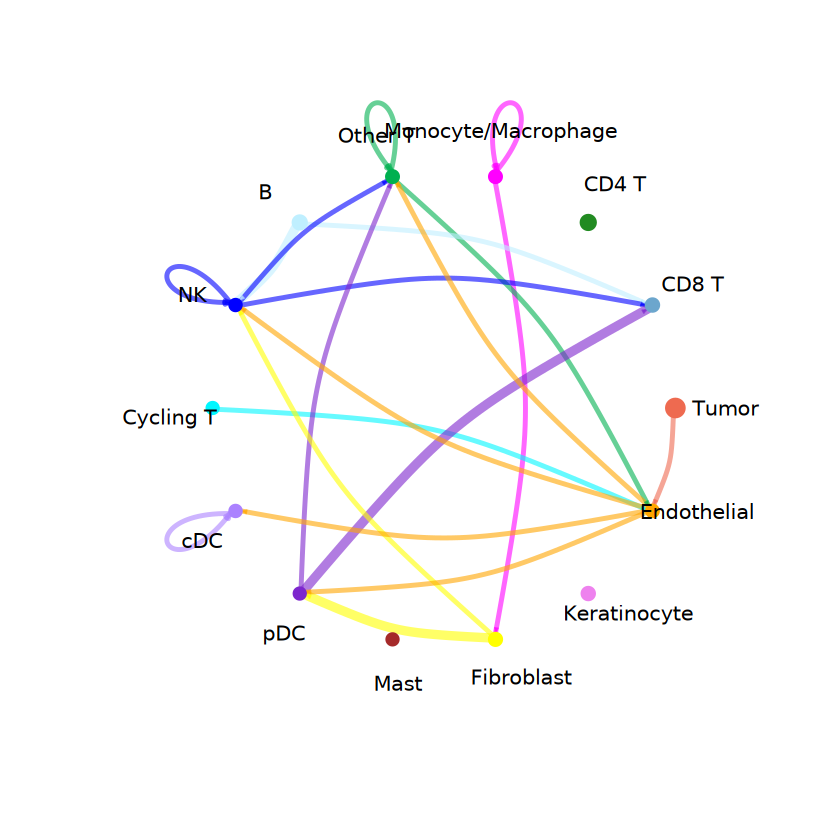

In [45]:
#pdf('./mDC_proportion_analysis/cell_communication_LR_celltype_res/cell_communication_LR_results_celltype_plot_no_zero_means_mregHigh_ixns.pdf',
   #  width = 11, height = 12)

print(netVisual_circle(mDChigh_weight_mat, vertex.weight = mDChigh_ixns_node_size,
                 color.use = celltype_cols, weight.scale = T, edge.weight.max = 3,
                       vertex.weight.max = max_node_size, vertex.label.cex=1, label.edge= F, 
                      title.name = 'mDC high interactions'))

#dev.off()

### 3. Plot mDC low interactions

In [34]:
### for mDC low interactions
#obj.RNA.mDClow <- subset(obj.RNA, subset = is_mDC_high == 0)
mDClow_ixns_node_size <- get_node_size(obj.RNA.mDClow, names(celltype_cols))
mDClow_ixns_weights <- get_edge_weights(mDC_low_ixns$interacting_cells, names(celltype_cols))
mDClow_weight_mat = data.matrix(mDClow_ixns_weights)

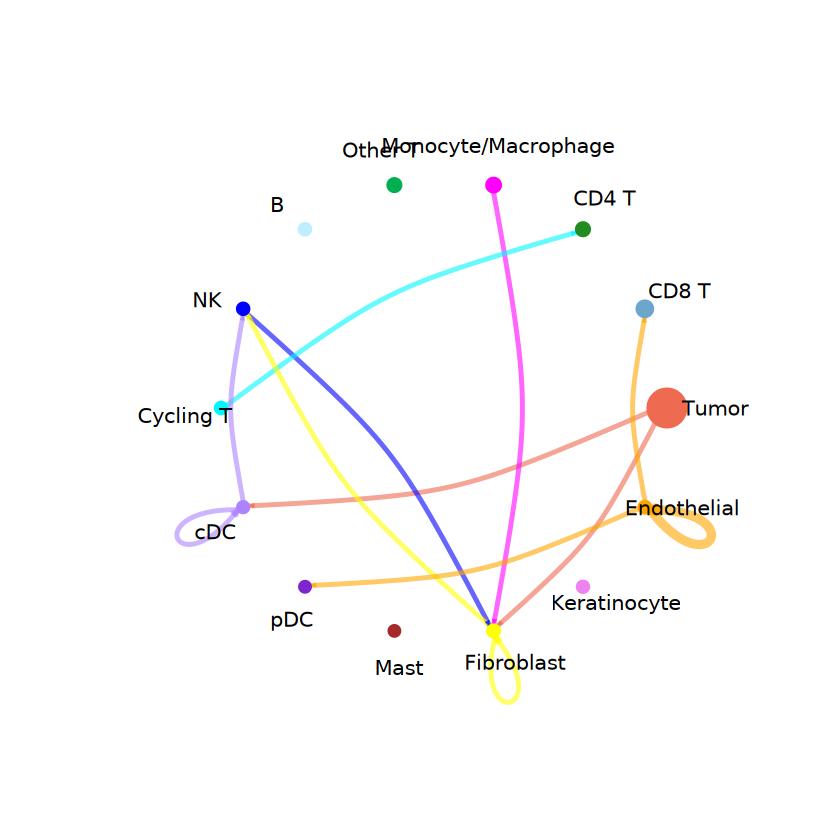

In [39]:
#pdf('./mDC_proportion_analysis/cell_communication_LR_celltype_res/cell_communication_LR_results_celltype_plot_no_zero_means_mregLow_ixns.pdf',
     # width = 11, height = 12)

print(netVisual_circle(mDClow_weight_mat, vertex.weight = mDClow_ixns_node_size,
                 color.use = celltype_cols, weight.scale = T, edge.weight.max = 3,
                       vertex.weight.max = max_node_size, vertex.label.cex=1, label.edge= F, 
                      title.name = 'mDC low interactions'))

#dev.off()

In [97]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /net/bmc-lab5/data/kellis/users/cbw3/conda/envs/r-kernel/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] Seurat_4.3.0.1      CellChat_1.6.1      bigmemory_4.6.4    
 [4] Biobase_2.58.0      BiocGenerics_0.44.0 ggplot2_3.5.0      
 [7] igraph_2.0.3        SeuratObject_5.0.1  sp_2.1-3           
[10] dplyr_1.1.4        

loaded via a namespace (and not attached):
  [1] uuid_1.2-0

## SCRATCHWORK: Not used 

## for Circos plots only 

In [10]:
library(tidyverse)

── Attaching core tidyverse packages ────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ ggplot2   3.5.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ──────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [11]:
#split interacting pair to ligand and receptor 
pair_splits <- lapply(ixn_summary_filt$interacting_pair, function(x) str_split(x, '_')[[1]])
                      
ixn_summary_filt$ligand <- unlist(lapply(pair_splits, function(x) x[1]))
ixn_summary_filt$receptor <- unlist(lapply(pair_splits, function(x) paste0(x[2:length(x)], 
                                                  collapse = '_')))                    
#split interacting cells to source and target 
celltype_splits <- lapply(ixn_summary_filt$interacting_cells, function(x) str_split(x, '[|]')[[1]])
ixn_summary_filt$source <- unlist(lapply(celltype_splits, function(x) x[1]))
ixn_summary_filt$target <- unlist(lapply(celltype_splits, function(x) x[2]))                           

In [12]:
### Cholesterol_byLIPA_RORA should be split differently
ixn_summary_filt[ixn_summary_filt$interacting_pair == 'Cholesterol_byLIPA_RORA',]$ligand = 'Cholesterol_byLIPA'
ixn_summary_filt[ixn_summary_filt$interacting_pair == 'Cholesterol_byLIPA_RORA',]$receptor = 'RORA'

add one column to indicate whether this was an mDC high or low interaction

In [13]:
ixn_summary_filt$is_mDC_high_ixn<- 0
ixn_summary_filt[ixn_summary_filt$sig_mean_coeff > 0,]$is_mDC_high_ixn <- 1

In [14]:
ixn_summary_filt

interacting_pair,interacting_cells,num_nonzero_mDC_high,num_nonzero_mDC_low,avg_nonzero_mean_mDC_high,avg_nonzero_mean_mDC_low,sig_mean_coeff,sig_mean_pval,ligand,receptor,source,target,is_mDC_high_ixn
<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
BAG6_NCR3,Cycling T|NK,7,9,0.3437143,0.3215556,6.233883,0.04335984,BAG6,NCR3,Cycling T,NK,1
VSIR_HLA-F,Cycling T|NK,8,12,0.7466250,0.7036667,3.027936,0.04376708,VSIR,HLA-F,Cycling T,NK,1
LCK_CD8_receptor,Cycling T|Other T,10,18,1.1251000,0.8052778,3.866378,0.02447026,LCK,CD8_receptor,Cycling T,Other T,1
SELE_GLG1,Endothelial|Fibroblast,8,9,0.6845000,0.6233333,4.394895,0.03225478,SELE,GLG1,Endothelial,Fibroblast,1
HEBP1_FPR3,Endothelial|Monocyte/Macrophage,8,15,0.4755000,0.3932667,6.162978,0.04823821,HEBP1,FPR3,Endothelial,Monocyte/Macrophage,1
SELE_GLG1,Endothelial|Monocyte/Macrophage,6,7,0.6215000,0.5385714,4.216198,0.04073645,SELE,GLG1,Endothelial,Monocyte/Macrophage,1
SELE_GLG1,Endothelial|Tumor,6,6,0.6216667,0.5193333,5.393709,0.03220817,SELE,GLG1,Endothelial,Tumor,1
SELE_GLG1,Endothelial|cDC,7,8,0.5618571,0.5027500,4.385839,0.03814374,SELE,GLG1,Endothelial,cDC,1
CD44_SELE,Fibroblast|Endothelial,8,9,1.0692500,0.9388889,2.759536,0.03230183,CD44,SELE,Fibroblast,Endothelial,1


## 2. options for generating expression table 
a. separate mDC high and low interactions - cellChat function 
b. using binary value (mDC low interaction or mDC high interaction)
c. using LR coefficients (harder because I would have to change the code to make the center at 0)

### option B: using binary values

In [15]:
## generate expression table using whether the interaction is predictive of mDC high or low 
mDC_low_high_exp <- data.frame(rbind(as.matrix(ixn_summary_filt[c('ligand', 'is_mDC_high_ixn', 
                                                 'source')]), 
                     as.matrix(ixn_summary_filt[c('receptor', 'is_mDC_high_ixn', 
                                       'target')])))
colnames(mDC_low_high_exp) <- c('gene', 'mean_exp', 'cell_type')
mDC_low_high_exp$mean_exp <- as.numeric(mDC_low_high_exp$mean_exp)


#add random noise to the 0/1 values, as the plot function cannot take in only binary values
set.seed(2020) #to get the same values each time
mDC_low_high_exp <- mDC_low_high_exp %>% mutate(mean_exp = jitter(mean_exp, factor = 0.5))

In [16]:
#separate the low and high interactions
mDC_low_high_exp

gene,mean_exp,cell_type
<chr>,<dbl>,<chr>
BAG6,1.029380568,Cycling T
VSIR,0.978845152,Cycling T
LCK,1.023700363,Cycling T
SELE,0.995378227,Endothelial
HEBP1,0.927219437,Endothelial
SELE,0.913476877,Endothelial
SELE,0.925830523,Endothelial
SELE,0.978623586,Endothelial
CD44,0.900516540,Fibroblast


In [334]:
# average any duplicated celltype/gene pairs
#summarize expression table (only one value allowed for each cell type/gene pair)
mDC_low_high_exp_summarized <- mDC_low_high_exp %>% group_by(cell_type, gene) %>% summarize(mean(mean_exp))
colnames(mDC_low_high_exp_summarized)[3] <- 'mean_exp'

head(mDC_low_high_exp_summarized)

`summarise()` has grouped output by 'cell_type'. You can override using the
`.groups` argument.


cell_type,gene,mean_exp
<chr>,<chr>,<dbl>
CD4 T,LTB,-0.06500978
Cycling T,LCK,1.02938057
Endothelial,HEBP1,0.97884515
Endothelial,LTBR,-0.06064088
Fibroblast,JAG1,1.02370036
Fibroblast,LTBR,-0.08442582


### option C: using LR coefficients generate expression table 

In [249]:
mDC_low_exp <- data.frame(rbind(as.matrix(ixn_summary_filt[c('ligand', 'sig_mean_coeff', 
                                                 'source')]), 
                     as.matrix(ixn_summary_filt[c('receptor', 'sig_mean_coeff', 
                                       'target')])))
colnames(mDC_low_exp) <- c('gene', 'mean_exp', 'cell_type')
mDC_low_exp$mean_exp <- as.numeric(mDC_low_exp$mean_exp)

                     
mDC_high_exp <- data.frame(rbind(as.matrix(ixn_summary_filt[c('ligand', 'sig_mean_coeff', 
                                                 'source')]), 
                     as.matrix(ixn_summary_filt[c('receptor', 'sig_mean_coeff', 
                                       'target')])))
colnames(mDC_high_exp) <- c('gene', 'mean_exp', 'cell_type')
mDC_high_exp$mean_exp <- as.numeric(mDC_high_exp$mean_exp)


In [ ]:
#summarize expression table (only one value allowed for each cell type/gene pair)
mDC_high_exp_summarized <- mDC_high_exp %>% group_by(cell_type, gene) %>% summarize(mean(mean_exp))
colnames(mDC_high_exp_summarized)[3] <- 'mean_exp'

mDC_low_exp_summarized <- mDC_low_exp %>% group_by(cell_type, gene) %>% summarize(mean(mean_exp))
colnames(mDC_low_exp_summarized)[3] <- 'mean_exp'

## 3. Make plots 

use CCPlotR to generate interaction 
cc_circos, option B
ligands, receptors, cell types involved, weight of edges is the mean score 

In [207]:
# cell type colors from other plots
celltype_cols = c('Endothelial' = 'orange',
               'Keratinocyte' = 'violet', 'Fibroblast' = 'yellow', 
               'Mast' = 'brown', 'pDC' = 'purple3',
               'cDC' = 'mediumpurple1', 'Cycling T' = '#00F7ff', 
               'NK' = 'blue', 'B' = 'lightblue1', 
               'Other T' = '#00B050', 'Monocyte/Macrophage' = 'magenta',
               'CD4 T' = 'forestgreen', 'CD8 T' = 'skyblue3', 
               'Tumor' = 'coral2')

In [17]:
library(CCPlotR)
data(toy_data, toy_exp, package = 'CCPlotR')


Warning message:
“replacing previous import ‘ggh4x::guide_axis_logticks’ by ‘ggplot2::guide_axis_logticks’ when loading ‘CCPlotR’”


In [316]:
head(ixn_summary_filt)

,interacting_pair,interacting_cells,num_nonzero_mDC_high,num_nonzero_mDC_low,avg_nonzero_mean_mDC_high,avg_nonzero_mean_mDC_low,sig_mean_coeff,sig_mean_pval,ligand,receptor,source,target,is_mDC_high_ixn
,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,LCK_CD8_receptor,Cycling T|Other T,10,18,1.1251000,0.8052778,3.866378,0.02447026,LCK,CD8_receptor,Cycling T,Other T,1
2,HEBP1_FPR3,Endothelial|Monocyte/Macrophage,8,15,0.4755000,0.3932667,6.162978,0.04823821,HEBP1,FPR3,Endothelial,Monocyte/Macrophage,1
3,JAG1_VASN,Fibroblast|Fibroblast,11,22,0.4560000,0.4045000,6.122459,0.04503843,JAG1,VASN,Fibroblast,Fibroblast,1
4,Cholesterol_byLIPA_RORA,Monocyte/Macrophage|Other T,7,24,0.6078571,0.6720833,-3.566604,0.04345473,Cholesterol,byLIPA_RORA,Monocyte/Macrophage,Other T,0
5,CD86_CD28,cDC|Other T,9,16,0.5158889,0.4066875,8.986546,0.03296139,CD86,CD28,cDC,Other T,1
6,NECTIN2_TIGIT,cDC|Other T,10,17,0.4114000,0.4232941,8.941251,0.02384728,NECTIN2,TIGIT,cDC,Other T,1


### option A: plot interactions between cell types (specific interactions not shown)

In [48]:
library(CellChat)

Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:lubridate’:

    %--%, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package:tibble’:

    as_data_frame


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




### select columns from data for plot
#### option B: binary values to indicate mDC high or low predictive value

In [336]:
# combine all results onto one plot 

#source	target	ligand	receptor	score
mDC_low_high_ixn_summary_filt <- ixn_summary_filt %>% select(c('source', 'target', 'ligand', 
                             'receptor'))

mDC_low_high_ixn_summary_filt$score <- 0
mDC_low_high_ixn_summary_filt$score <- ifelse(ixn_summary_filt$is_mDC_high_ixn == 1,
                                 ixn_summary_filt$avg_nonzero_mean_mDC_high,
                             ixn_summary_filt$avg_nonzero_mean_mDC_low)

In [337]:
head(mDC_low_high_ixn_summary_filt)

,source,target,ligand,receptor,score
,<chr>,<chr>,<chr>,<chr>,<dbl>
1,Cycling T,Other T,LCK,CD8_receptor,1.1251000
2,Endothelial,Monocyte/Macrophage,HEBP1,FPR3,0.4755000
3,Fibroblast,Fibroblast,JAG1,VASN,0.4560000
4,Monocyte/Macrophage,Other T,Cholesterol_byLIPA,RORA,0.6720833
5,cDC,Other T,CD86,CD28,0.5158889
6,cDC,Other T,NECTIN2,TIGIT,0.4114000


#### plot results 

In [348]:
#save plot 
pdf('/home/cbw3/data/figure_generation/Figure6/ccc_diffexp_LR_results/ccc_diffexp_LR_plot_celltype.pdf',
      width = 12, height = 13)

options(repr.plot.height = 14, repr.plot.width = 12)
cc_circos(mDC_low_high_ixn_summary_filt, exp_df = mDC_low_high_exp_summarized, option = 'C', 
         cell_cols = celltype_cols, palette = 'RdBu') #, n_top_ints = 10)

dev.off()

png 
  2

In [349]:
# save final table of interactions for plot 
write.csv(mDC_low_high_ixn_summary_filt, './ccc_diffexp_LR_results/ccc_diffexp_LR_summary_filt_celltype.csv')
write.csv(mDC_low_high_exp, './ccc_diffexp_LR_results/ccc_diffexp_LR_exp_celltype.csv')
write.csv(ixn_summary_filt, './ccc_diffexp_LR_results/ccc_diffexp_LR_summary_celltype.csv')

### option B: two separate plots showing edge weights for either mDC high or mDC low (not finished)

In [214]:
#source	target	ligand	receptor	score
mDC_high_ixn_summary_filt <- ixn_summary_filt %>% select(c('source', 'target', 'ligand', 
                             'receptor', 'avg_nonzero_mean_mDC_high'))

colnames(mDC_high_ixn_summary_filt)[5] <- 'score'

mDC_low_ixn_summary_filt <- ixn_summary_filt %>% select(c('source', 'target', 'ligand', 
                             'receptor', 'avg_nonzero_mean_mDC_low'))

colnames(mDC_low_ixn_summary_filt)[5] <- 'score'


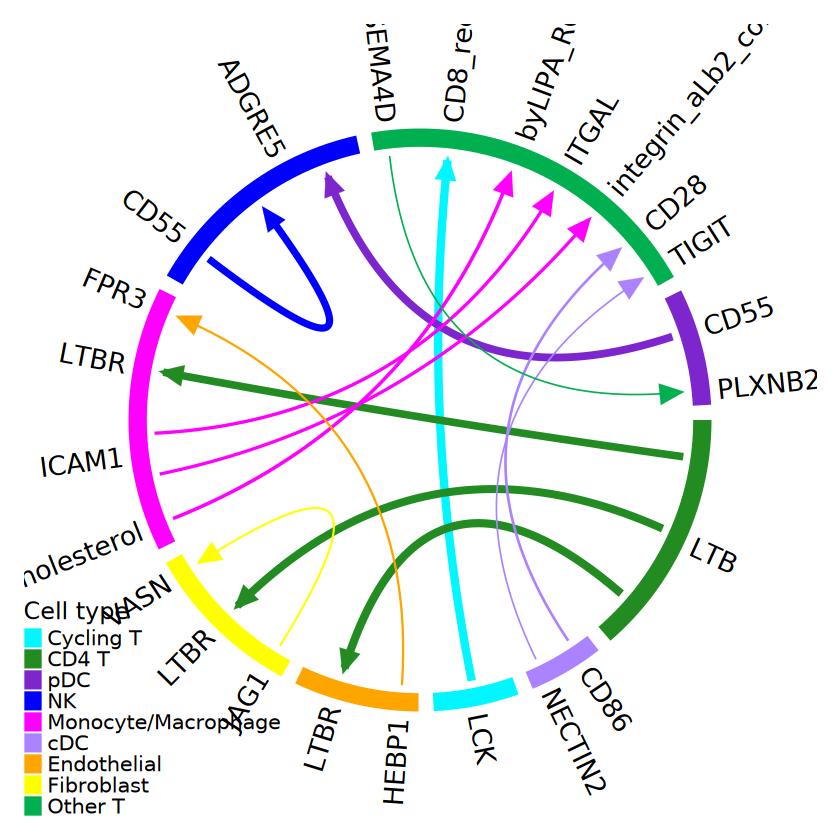

In [260]:
cc_circos(mDC_high_ixn_summary_filt, option = 'B', cell_cols = celltype_cols) #, n_top_ints = 10)

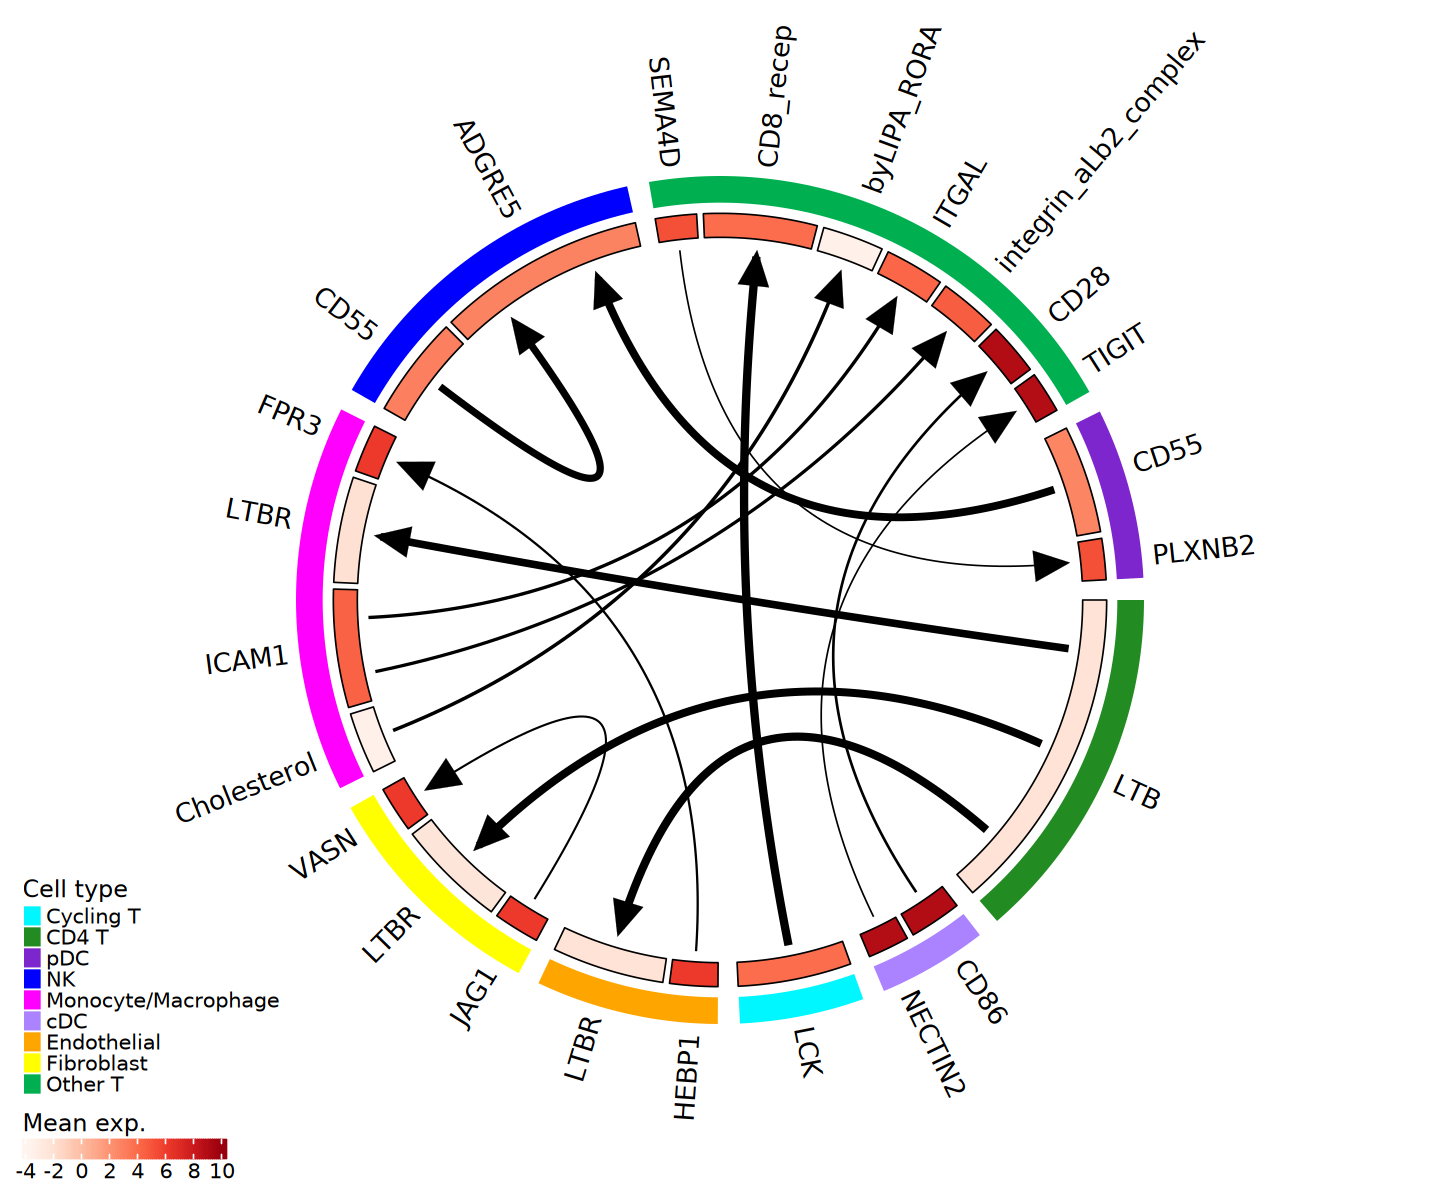

In [299]:
options(repr.plot.height = 10, repr.plot.width = 12)
cc_circos(mDC_high_ixn_summary_filt, exp_df = mDC_high_exp_summarized, option = 'C', 
         cell_cols = celltype_cols, palette = 'Reds') #, n_top_ints = 10)

In [290]:
colorpal

[1] "#B2182B" "#EF8A62" "#FDDBC7" "#F7F7F7" "#D1E5F0" "#67A9CF" "#2166AC"

In [298]:
options(repr.plot.height = 10, repr.plot.width = 12)
cc_circos(mDC_high_ixn_summary_filt, exp_df = mDC_high_exp_summarized, option = 'C', 
         cell_cols = celltype_cols, palette = 'colorpal') #, n_top_ints = 10)

ERROR: Error in if (!(name %in% namelist)) {: the condition has length > 1


In [ ]:
netVisual_circle(
  net,
  color.use = NULL,
  title.name = NULL,
  sources.use = NULL,
  targets.use = NULL,
  idents.use = NULL,
  remove.isolate = FALSE,
  top = 1,
  weight.scale = FALSE,
  vertex.weight = 20,
  vertex.weight.max = NULL,
  vertex.size.max = NULL,
  vertex.label.cex = 1,
  vertex.label.color = "black",
  edge.weight.max = NULL,
  edge.width.max = 8,
  alpha.edge = 0.6,
  label.edge = FALSE,
  edge.label.color = "black",
  edge.label.cex = 0.8,
  edge.curved = 0.2,
  shape = "circle",
  layout = in_circle(),
  margin = 0.2,
  vertex.size = NULL,
  arrow.width = 1,
  arrow.size = 0.2
)

In [239]:
all_ixns_node_size

Endothelial        Keratinocyte          Fibroblast                Mast 
               5647                6103                7747                 421 
                pDC                 cDC           Cycling T                  NK 
                675                2160                2884                3167 
                  B             Other T Monocyte/Macrophage               CD4 T 
              10165               10248               13052               17952 
              CD8 T               Tumor 
              21146              114579